In [443]:
import pandas as pd
import numpy as np
import warnings
import time
import matplotlib.pyplot as plt

# one file read three times, can be optimized
m_lt = pd.read_excel('gorilla_test_data.xlsx', sheet_name='meter_list')
ft = pd.read_excel('gorilla_test_data.xlsx', sheet_name='forecast_table')
rate = pd.read_excel('gorilla_test_data.xlsx', sheet_name='rate_table')


# rate["aq_max_kwh"].loc[np.isnan(rate["aq_max_kwh"])] = np.inf 
rate.loc[np.isnan(rate["aq_max_kwh"]), 'aq_max_kwh'] = np.inf
# def daily_cost_p(date, meter):
#     return rate, forecast

In [444]:
ft

,meter_id,date,kwh
0,14676236,2020-06-01,22.070768
1,14676236,2020-06-02,19.170720
2,14676236,2020-06-03,23.555111
3,14676236,2020-06-04,18.220712
4,14676236,2020-06-05,14.196134
...,...,...,...
3407,88357331,2022-09-27,441.014725
3408,88357331,2022-09-28,441.512055
3409,88357331,2022-09-29,437.240657
3410,88357331,2022-09-30,517.608354


### Roughwork

In [445]:
k = rate.loc[0:len(rate):38*3]
print(k, '\n')
p = np.arange(0,len(rate),38*3, dtype = int)
print(p)
pi = np.arange(38*3,len(rate),38*3, dtype = int)
pi = np.append(pi, pi[-1])
print(pi)
ol = np.append(p[1:],p[-1])
print(ol)
df_LookupTable = pd.DataFrame({'Start': rate['date'].iloc[p[:-1]].values,
                                   'Stop': rate['date'].iloc[ol[:-1]].values,
                                   'Rate': rate['rate_p_per_kwh'].iloc[p[:-1]].values })
print(df_LookupTable,'\n')

,date,exit_zone,aq_min_kwh,aq_max_kwh,rate_p_per_kwh
0,2020-04-01,EA1,0,73200.0,0.2652
1,2020-04-01,EA1,73200,732000.0,0.1980
2,2020-04-01,EA1,732000,inf,0.2875
3,2020-04-01,EA2,0,73200.0,0.2970
4,2020-04-01,EA2,73200,732000.0,0.1524
...,...,...,...,...,...
1135,2024-10-01,WM2,73200,732000.0,0.4537
1136,2024-10-01,WM2,732000,inf,0.7534
1137,2024-10-01,WM3,0,73200.0,0.7263
1138,2024-10-01,WM3,73200,732000.0,0.6109


# Problem 1

In [446]:
# def calculate_cost_energy(m_lt, ft):
#     """
#     Calculate total consumption and the cost of meter in the forcast period

#     Parameters:
#     m_lt (pd.DataFrame): meter_list in the given dataset
#     ft (pd.DataFrame): forecast_table in the given dataset
#     Returns:
#     pd.DataFrame: table containing Total_consumption and cost of the given meter
#     """
#     meter_energy = pd.DataFrame({"Meter":[], 
#                             "Total_Consumption":[],
#                             "Cost":[]})
    
#     k = -1
#     kwh_sum = []
#     cost_sum = []
    
    
#     ft['rates'] = 0
#     ft_gr = ft.groupby('meter_id')
#     # find the upper limit of max. days according to rate_table
#     ed = pd.DataFrame({0:['2021-04-01','2021-10-01']})
#     ed[0] = pd.to_datetime(ed[0])
#     days_lim = (ed[0][1] - ed[0][0]) / np.timedelta64(1, 'D')
    
    
#     for name, group in ft_gr:
#         k += 1
#         i = 0
#         exit_zone = m_lt['exit_zone'].iloc[k]
#         aq = m_lt['aq_kwh'].iloc[k]

#         indices = group.index
#         print('\n',group)

#         for ft_date in group['date']:

#             if rate['date'].iloc[-1]>=group['date'][indices[i]]:


#                 cp = rate[(rate['exit_zone']==exit_zone)
#                           *(group['date'][indices[i]]>= rate['date'])
#                           *((group['date'][indices[i]] - rate['date'])/ np.timedelta64(1, 'D') < days_lim)].index.values

#                 ac_index = [cp[j] for j in range(len(cp)) if rate['aq_min_kwh'][cp[j]] <= aq <= rate['aq_max_kwh'][cp[j]]]
# #                 print('\n',ac_index)
# #                 print(cp, 'cp \n')
# #                 print(group['date'][indices[i]], 'forcast_date\n')
# #                 group.loc[indices[i], 'rates'] = rate['rate_p_per_kwh'].iloc[ac_index[-1]]
#                 group['rates'].loc[indices[i]] = rate['rate_p_per_kwh'].iloc[ac_index[-1]]
    
#                 i+=1



#             else:
#                 break

#         kwh_sum.append(sum(group['kwh']))
#         cost_sum.append(sum(group["kwh"]*group['rates']*0.01))

#     meter_energy["Meter"] =  m_lt['meter_id']
#     meter_energy["Total_Consumption"] = kwh_sum
#     meter_energy["Cost"] = cost_sum

#     return meter_energy 



        
   
    

## Assumptions
    1. Exit zones are assumed to be in same order for each date in the rate_table.
    2. Number of energy bands with  min and max energy values are assumed to be uniform across meters.
    3. Time duration of forcast and start_date in rate_table are assumed to be consistent across meters.


In [460]:
def calculate_cost_energy_optimized(m_lt, ft):
    """
    Calculate total consumption and the cost of meter in the forcast period

    Parameters:
    m_lt (pd.DataFrame): meter_list in the given dataset
    ft (pd.DataFrame): forecast_table in the given dataset
    Returns:
    pd.DataFrame: table containing Total_consumption and cost for the given meters
    """
    meter_energy = pd.DataFrame({"Meter":[], 
                            "Total_Consumption":[],
                            "Cost":[]})


    kwh_sum = []
    cost_sum = []

    nb_days = (ft['date'].iloc[-1] - ft['date'].iloc[0])/np.timedelta64(1, 'D') + 1
    print(nb_days,'nb of days \n')
    zones = np.unique(rate['exit_zone'])
    size_zones = len(zones)
    nb_bands = 3 # HARDCODED 
    nb_meters = len(m_lt)


    # selecting energy bands in rate_table for each meter and inserting in meter list
    meter_bands = pd.DataFrame({"minp":rate["aq_min_kwh"].iloc[0:nb_bands].values,
                          "maxp":rate["aq_max_kwh"].iloc[0:nb_bands].values})
    s1=meter_bands["minp"].values
    s2=meter_bands["maxp"].values
    s=m_lt.aq_kwh.values[:,None]
    result = np.dot((s>=s1)&(s<s2),np.arange(0,nb_bands, dtype = int))
    m_lt["range"] = result
   # print('METER LIST \n', m_lt,'\n')


    
    for i in range(len(m_lt)):
    # for i in range(1):
        df_1 = ft.loc[i*nb_days:(i+1)*nb_days]
        exit_zone = m_lt['exit_zone'].iloc[i]
        # print(exit_zone,'exit zone \n')
        start1_index = np.argwhere(zones == exit_zone)
        start2_index = m_lt['range'].loc[i]
        start_index = start1_index * nb_bands + start2_index
        start_indices = np.arange(start_index, len(rate), size_zones*nb_bands, dtype = int)
        df_LookupTable = pd.DataFrame({'Start': rate['date'].loc[start_indices[:-1]].values,
                                       'Stop': rate['date'].loc[start_indices[1:]].values,
                                       'Rate': rate['rate_p_per_kwh'].loc[start_indices[:-1]].values })

        result = np.dot(
            (df_1['date'].values[:, None] >= df_LookupTable['Start'].values) &
            (df_1['date'].values[:, None] <= df_LookupTable['Stop'].values),
            df_LookupTable['Rate'])

        kwh_sum.append(sum(df_1['kwh'].values))
        cost_sum.append(0.01*np.dot(result,df_1['kwh'].values))

    #     ft.loc[i*nb_days:(i+1)*nb_days,'rate'] = result
    #     print(df_LookupTable)


    meter_energy["Meter"] =  m_lt['meter_id']
    meter_energy["Total_Consumption"] = kwh_sum
    meter_energy["Cost"] = cost_sum

    meter_energy = meter_energy.round(2)
    return meter_energy








## Solution 1


In [449]:
# meter_energy = calculate_cost_energy(m_lt, ft)
# print(meter_energy)
meter_energy = calculate_cost_energy_optimized(m_lt, ft)
print('meter_energy')


853.0 nb of days 

METER LIST 
    meter_id  aq_kwh exit_zone  range
0  14676236   28978       EA1      0
1  34509937   78324       SO1      1
2  50264822  265667       NT1      1
3  88357331  484399       SE2      1 

EA1 exit zone 

SO1 exit zone 

NT1 exit zone 

SE2 exit zone 

meter_energy


# Problem 2

In [450]:
zones = np.unique(rate['exit_zone'])
print('\n ', zones)
print('\n ', len(zones))



  ['EA1' 'EA2' 'EA3' 'EA4' 'EM1' 'EM2' 'EM3' 'EM4' 'LC' 'LO' 'LS' 'LT' 'LW'
 'NE1' 'NE2' 'NE3' 'NO1' 'NO2' 'NT1' 'NT2' 'NT3' 'NW1' 'NW2' 'SC1' 'SC2'
 'SC4' 'SE1' 'SE2' 'SO1' 'SO2' 'SW1' 'SW2' 'SW3' 'WA1' 'WA2' 'WM1' 'WM2'
 'WM3']

  38


In [451]:
def random_meter_list(input_meters, total_zones):
    new_meter_list = pd.DataFrame()
    total_meter_cap = np.random.randint(20000, high=1000000,
                               size=input_meters)
    zone_indices = np.random.randint(0, high=total_zones,
                               size=input_meters)
    meter_names = np.random.randint(20000000,
                               size=input_meters)
    
    new_meter_list['meter_id'] = meter_names
    new_meter_list['aq_kwh'] = total_meter_cap
    new_meter_list['exit_zone'] = zones[zone_indices]
    return new_meter_list
    

## Solution 2

In [452]:

total_zones = len(zones)
input_meters = 2
new_meter_list = random_meter_list(input_meters, total_zones)
print('\n',new_meter_list)






    meter_id  aq_kwh exit_zone
0  12314951   34551       SO1
1   5036937   25400       NE3


# Problem 3

In [453]:
def random_forcast_table(meter_ids, start_date, end_date):
    
    new_forcast_table = pd.DataFrame()
    dates = pd.date_range(start=start_date, end=end_date)
    all_meter = np.array([])
    all_date = []
    all_kwh = np.array([])
    for i in range(len(meter_ids)):
        all_meter = np.append(all_meter, np.ones(len(dates))*meter_ids[i])
        all_date.extend(dates)
        all_kwh = np.append(all_kwh, np.random.normal(50, 3, len(dates)))
        
    new_forcast_table['meter_id'] = all_meter.astype(np.int32)
    new_forcast_table['date'] = all_date
    new_forcast_table['kwh'] = all_kwh
    return new_forcast_table 

## Solution 3

In [454]:

meter_ids = new_meter_list['meter_id']
start_date = '1/1/2020'
end_date = '1/24/2020'
# start date and end date of all meters are same
print('\n', dates)
new_forcast_table = random_forcast_table(meter_ids, start_date, end_date)
print('\n', new_forcast_table)


 DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24'],
              dtype='datetime64[ns]', freq='D')

     meter_id       date        kwh
0   12314951 2020-01-01  53.582621
1   12314951 2020-01-02  46.781991
2   12314951 2020-01-03  50.542456
3   12314951 2020-01-04  52.798312
4   12314951 2020-01-05  49.999212
5   12314951 2020-01-06  54.928038
6   12314951 2020-01-07  54.165536
7   12314951 2020-01-08  52.494109
8   12314951 2020-01-09  46.249386
9   12314951 2020-01-10  51.303119
10  12314951 2020-01-11  49.831943
11  12314951 2020-01-12  47.302517
12  12314951 2020-01-13  51.940905
13  12314951 2020-01-14  49.683

## Solution 4 , part a

In [455]:
# 2
total_zones = len(zones)
input_meters = 2
new_meter_list = random_meter_list(input_meters, total_zones)
print(new_meter_list,'\n')

# 3
meter_ids = new_meter_list['meter_id']
start_date = '5/5/2020'
end_date = '10/24/2024'

try:
    new_forcast_table = random_forcast_table(meter_ids, start_date, end_date)
    # print(new_forcast_table)
    
    # 4
#     new_meter_energy = calculate_cost_energy(new_meter_list, new_forcast_table)
    new_meter_energy = calculate_cost_energy_optimized(new_meter_list, new_forcast_table)
    print(new_meter_energy)
except:
    if (pd.to_datetime(start_date) < rate['date'].iloc[0]) | (pd.to_datetime(end_date) > rate['date'].iloc[-1]):
        print("Invalid dates")
        print("Change the input the dates for calculating the transportation costs")
        
# start date and end date of all meters are same
# end date should be atleast equal latest date in rate_table to calculate rate
# start date should be more than the minimum in the rate table






   meter_id  aq_kwh exit_zone
0  13848003  223089       SW2
1   8452701  399336       WA1 

1634.0 nb of days 

METER LIST 
    meter_id  aq_kwh exit_zone  range
0  13848003  223089       SW2      1
1   8452701  399336       WA1      1 

SW2 exit zone 

WA1 exit zone 

      Meter  Total_Consumption    Cost
0  13848003           81634.58  221.61
1   8452701           81543.54  308.97


## Solution 4, part b

In [479]:
# 2


total_zones = len(zones)
input_meters = np.array([10, 20, 30, 40, 50])
start_date = '5/5/2020'
intervals = [29, 89, 179, 359, 2*359]
end_date = pd.to_datetime(intervals, unit='D', origin = pd.to_datetime(start_date))
print(end_date,'\n')
total_meters = len(input_meters)
total_intervals = len(intervals)

time_all = np.empty([total_meters,total_intervals])
start = 0
end = 0
for m in range(len(input_meters)):
    start = time.time()
    new_meter_list = random_meter_list(input_meters[m], total_zones)
#     print(new_meter_list,'\n')

    # 3
    meter_ids = new_meter_list['meter_id']
    for date_itr in range(len(end_date)):
        try:
            new_forcast_table = random_forcast_table(meter_ids, start_date, end_date[date_itr])
            # print(new_forcast_table)

            # 4
        #     new_meter_energy = calculate_cost_energy(new_meter_list, new_forcast_table)
            new_meter_energy = calculate_cost_energy_optimized(new_meter_list, new_forcast_table)
            end = time.time()
            print(new_meter_energy,'\n')
            
            time_all[m,date_itr] = end - start
        except:
            if (pd.to_datetime(start_date) < rate['date'].iloc[0]) | (pd.to_datetime(end_date[date_itr]) > rate['date'].iloc[-1]):
                print("Change the input the dates for calculating the transportation costs \n")

print(time_all)
# print command between time mapping can be commented to get better time estimates
# start date and end date of all meters are same
# end date should be atleast equal latest date in rate_table to calculate rate
# start date should be more than the minimum in the rate table

DatetimeIndex(['2020-06-03', '2020-08-02', '2020-10-31', '2021-04-29',
               '2022-04-23'],
              dtype='datetime64[ns]', freq=None) 

30.0 nb of days 

      Meter  Total_Consumption  Cost
0   8371354            1543.26  2.52
1  17387847            1554.15  4.44
2  11643248            1541.80  2.74
3   5831650            1545.56  4.25
4   1107159            1549.11  3.63
5  13575086            1546.12  2.56
6    767101            1526.43  3.51
7   7879386            1548.47  3.38
8  11707522            1540.21  2.73
9  17755501            1517.22  3.47 

90.0 nb of days 

      Meter  Total_Consumption   Cost
0   8371354            4526.90   7.41
1  17387847            4529.56  12.94
2  11643248            4527.00   8.04
3   5831650            4563.62  12.55
4   1107159            4535.71  10.64
5  13575086            4533.22   7.51
6    767101            4529.60  10.40
7   7879386            4620.56  10.08
8  11707522            4493.55   7.96
9  17755501            

360.0 nb of days 

       Meter  Total_Consumption   Cost
0   16174771           18094.26  52.00
1   13361913           17984.23  39.60
2    5922564           18054.09  53.80
3    3331779           17989.20  57.49
4   12982578           18052.72  34.75
5    6557920           18104.77  40.94
6    9520206           17926.08  31.88
7   17559267           18069.32  44.47
8    5784215           18188.31  54.69
9   17233328           18147.09  49.96
10    572752           18065.54  55.13
11   4260871           18013.07  55.07
12   4501313           17981.15  57.29
13    396912           18103.74  50.76
14    996035           17995.34  36.16
15    585450           18083.31  56.14
16  16296164           18015.33  56.18
17  19049139           18042.89  48.51
18  13345245           18049.58  43.23
19  16989249           18065.16  34.75
20   6315966           18057.84  34.85
21    229377           18053.94  42.79
22   9806587           18065.21  36.31
23  17846105           17923.02  56.40
24   4

       Meter  Total_Consumption  Cost
0   16232452            1513.38  3.03
1    4563095            1538.97  4.42
2    9398195            1536.58  4.18
3    8131660            1510.57  3.42
4     244818            1551.95  3.76
5    7325880            1530.38  3.06
6    9482640            1562.98  4.59
7   17748462            1545.06  4.43
8    2882690            1549.69  2.95
9    6084199            1557.98  3.40
10  13181741            1578.35  4.97
11  14819927            1544.67  3.06
12   8368354            1548.23  4.74
13   3702462            1549.78  3.62
14  12584821            1535.64  4.78
15   4273840            1544.94  2.74
16   1200856            1550.59  4.33
17  11783394            1523.69  3.55
18  10552285            1530.82  4.69
19  12536957            1532.77  3.07
20  19389784            1559.61  3.12
21    899039            1548.92  2.74
22  10873481            1540.48  3.64
23   9194449            1528.81  3.33
24  11648236            1540.52  4.79
25   7257495

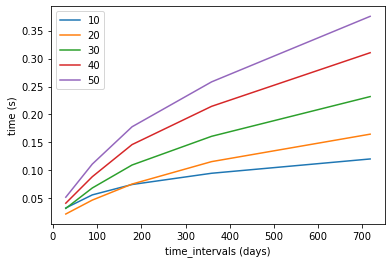

In [480]:
plt.figure()
for m in range(len(input_meters)):
    
    plt.plot(intervals, time_all[m,:])
    plt.xlabel('time_intervals (days)')
    plt.ylabel('time (s)')
plt.legend(input_meters)
plt.show()

# Solution 5

## Assumptions
1. Exit zones are assumed to be in same order for each date in the rate_table.
2. Number of energy bands with  min and max energy values are assumed to be uniform across meters.
3. Time duration of forcast and start_date in rate_table are assumed to be consistent across meters.
    
### Reading excel files
1. Excel files is read three times for each table. For a sizable dataset it can be read at once.
2. For large datasets with high forcast duration and number of meters, reading data can be optimized using python libraries
    a. Large datasets can be read from cloud. Divinding larges datasets into small chunks increase the data transfer and saves the loaded transfer incase of network interruption. For e.g. First step of sorting the data by exit zone can be done on server and afterwards importing the small files from the server. 


### Computation time
1. The computation graph can be improved by providing average time values over many iterations. This ensures cancelling noise during processing time.